In [1]:
import spym
import numpy as np
import pandas as pd
import numdifftools as nd
import plotly.express as px
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score

np.random.seed(42)
pd.set_option('display.max_columns', None)

In [2]:
# <1101> - potencjalna linia ilości punktów spektroskopii
# dI/dU__y - ilość krzywych spektroskopowych 
# <1076-7> - nazwa pliku
# <1986> - rozmiar obrazka w px,
# <1322> - roxmiar obrazka w nm, 
# <1833> - ON (backward), OFF  (forward)
file = spym.load('data/2023-03-17-0163.SM4')
file

<xarray.Dataset>
Dimensions:                (dI/dU__x: 509, dI/dU__y: 30, Current__x: 509,
                            Current__y: 30, dI/dU__Forward_x: 256,
                            dI/dU__Forward_y: 256, dI/dU__Backward_x: 256,
                            dI/dU__Backward_y: 256, Topography_Forward_x: 256,
                            Topography_Forward_y: 256,
                            Topography_Backward_x: 256,
                            Topography_Backward_y: 256)
Coordinates:
  * dI/dU__x               (dI/dU__x) float64 -2.4 -2.391 -2.381 ... 2.396 2.406
  * dI/dU__y               (dI/dU__y) uint32 0 1 2 3 4 5 6 ... 24 25 26 27 28 29
  * Current__x             (Current__x) float64 -2.4 -2.391 ... 2.396 2.406
  * Current__y             (Current__y) uint32 0 1 2 3 4 5 ... 24 25 26 27 28 29
  * dI/dU__Forward_x       (dI/dU__Forward_x) float64 0.0 ... 5.977e-09
  * dI/dU__Forward_y       (dI/dU__Forward_y) float64 0.0 ... 5.977e-09
  * dI/dU__Backward_x      (dI/dU__Backward_x) float64 0.0 ... 5.977e-09
  * dI/dU__Backward_y      (dI/dU__Backward_y) float64 0.0 ... 5.977e-09
  * Topography_Forward_x   (Topography_Forward_x) float64 0.0 ... 5.977e-09
  * Topography_Forward_y   (Topography_Forward_y) float64 0.0 ... 5.977e-09
  * Topography_Backward_x  (Topography_Backward_x) float64 0.0 ... 5.977e-09
  * Topography_Backward_y  (Topography_Backward_y) float64 0.0 ... 5.977e-09
Data variables:
    dI/dU_                 (dI/dU__x, dI/dU__y) float64 0.08667 ... 0.0116
    Current_               (Current__x, Current__y) float64 -1.047e-10 ... 3....
    dI/dU__Forward         (dI/dU__Forward_x, dI/dU__Forward_y) float64 -1.01...
    dI/dU__Backward        (dI/dU__Backward_x, dI/dU__Backward_y) float64 -1....
    Topography_Forward     (Topography_Forward_x, Topography_Forward_y) float64 ...
    Topography_Backward    (Topography_Backward_x, Topography_Backward_y) float64 ...

In [3]:
dIdU = file['Current_']
dIdU

<xarray.DataArray 'Current_' (Current__x: 509, Current__y: 30)>
array([[-1.04675292e-10, -8.57543940e-11, -9.49096674e-11, ...,
        -1.37329101e-10, -1.19934081e-10, -9.00268549e-11],
       [-1.25732421e-10, -1.17187499e-10, -7.75146480e-11, ...,
        -9.88769525e-11, -9.03320307e-11, -1.01318359e-10],
       [-1.07421874e-10, -7.38525386e-11, -1.17797851e-10, ...,
        -8.81958002e-11, -8.85009760e-11, -1.34582519e-10],
       ...,
       [ 2.56652830e-10,  2.54821776e-10,  2.91748045e-10, ...,
         1.89208983e-11,  1.34277343e-11,  5.46264645e-11],
       [ 2.56652830e-10,  2.44140624e-10,  2.73437498e-10, ...,
         6.13403317e-11,  5.49316403e-11,  1.09863281e-11],
       [ 2.38342284e-10,  2.38342284e-10,  2.91442869e-10, ...,
         2.77709959e-11,  3.66210935e-11,  3.66210935e-11]])
Coordinates:
  * Current__x  (Current__x) float64 -2.4 -2.391 -2.381 ... 2.387 2.396 2.406
  * Current__y  (Current__y) uint32 0 1 2 3 4 5 6 7 ... 22 23 24 25 26 27 28 29
Attributes: (12/81)
    RHK_PRMdata:                           WinSpm 2003.00 Program Configurati...
    RHK_PageID:                         38602
    RHK_PageDataType:                   1
    RHK_PageDataTypeName:               RHK_DATA_LINE
    RHK_PageSourceType:                 0
    RHK_PageSourceTypeName:             RHK_SOURCE_RAW
    ...                                 ...
    setpoint_units:                     
    feedback_active:                    None
    feedback_pgain:                     0
    scan_angle:                         0.0
    time_per_point:                     1e-05
    filename:                           2023-03-17-0163.SM4

In [4]:
# nazwa pliku
dIdU.attrs['filename']

'2023-03-17-0163.SM4'

In [5]:
# rozmiar w px
tf = file['Topography_Forward']
tf.shape

(256, 256)

In [6]:
# rozmiar w nm
idx = dIdU.attrs['RHK_PRMdata'].find('<1322>')
dIdU.attrs['RHK_PRMdata'][idx+19:idx+32]

'6.0000e-009 m'

In [7]:
# forward czy backward
idx = dIdU.attrs['RHK_PRMdata'].find('<1833>')
f_or_b = True if dIdU.attrs['RHK_PRMdata'][idx+34:idx+36] == 'ON' else False
f_or_b

True

In [8]:
# oś X
dIdU.coords['Current__x'].values

array([-2.40005493, -2.39059448, -2.38113403, -2.37167358, -2.36221313,
       -2.35275269, -2.34329224, -2.33383179, -2.32437134, -2.31491089,
       -2.30545044, -2.29598999, -2.28652954, -2.27706909, -2.26760864,
       -2.25814819, -2.24868774, -2.23922729, -2.22976685, -2.2203064 ,
       -2.21084595, -2.2013855 , -2.19192505, -2.1824646 , -2.17300415,
       -2.1635437 , -2.15408325, -2.1446228 , -2.13516235, -2.1257019 ,
       -2.11624146, -2.10678101, -2.09732056, -2.08786011, -2.07839966,
       -2.06893921, -2.05947876, -2.05001831, -2.04055786, -2.03109741,
       -2.02163696, -2.01217651, -2.00271606, -1.99325562, -1.98379517,
       -1.97433472, -1.96487427, -1.95541382, -1.94595337, -1.93649292,
       -1.92703247, -1.91757202, -1.90811157, -1.89865112, -1.88919067,
       -1.87973022, -1.87026978, -1.86080933, -1.85134888, -1.84188843,
       -1.83242798, -1.82296753, -1.81350708, -1.80404663, -1.79458618,
       -1.78512573, -1.77566528, -1.76620483, -1.75674438, -1.74

In [9]:
# oś Y
dIdU.values[:, 0]

array([-1.04675292e-10, -1.25732421e-10, -1.07421874e-10, -9.15527338e-11,
       -1.20544433e-10, -8.60595698e-11, -8.94165034e-11, -1.34887694e-10,
       -8.91113276e-11, -8.14819331e-11, -1.28173827e-10, -8.78906245e-11,
       -8.33129878e-11, -1.23291015e-10, -7.84301753e-11, -8.81958002e-11,
       -1.18408202e-10, -7.65991206e-11, -8.14819331e-11, -1.15966796e-10,
       -5.79833981e-11, -8.48388667e-11, -1.20239257e-10, -7.99560542e-11,
       -8.14819331e-11, -1.01013183e-10, -7.23266597e-11, -5.92041012e-11,
       -1.23901366e-10, -7.84301753e-11, -7.11059566e-11, -9.06372065e-11,
       -7.29370113e-11, -6.83593746e-11, -1.03454589e-10, -7.81249995e-11,
       -6.74438472e-11, -1.03149413e-10, -6.53076168e-11, -6.19506832e-11,
       -1.08642577e-10, -5.85937496e-11, -5.79833981e-11, -1.06811523e-10,
       -5.92041012e-11, -5.70678707e-11, -9.09423823e-11, -6.28662106e-11,
       -5.43212887e-11, -9.91821283e-11, -6.62231441e-11, -5.70678707e-11,
       -8.78906245e-11, -

In [10]:
# tworzenie obiektu df
dataset = pd.DataFrame(dIdU.values, columns=[f'y{x}' for x in range(dIdU.coords['Current__y'].size)])
dataset['x'] = dIdU.coords['Current__x']

# przeszukiwanie metadanych w poszukiwaniu informacji ile krzywych zrobiono w jednym punkcie
idx = dIdU.attrs['RHK_PRMdata'].find('<1101>')
curves_per_point = int(dIdU.attrs['RHK_PRMdata'][idx+28:idx+29])

# wyznaczanie ilości krzywych i punktów pomiarowych
num_of_curves = dIdU.coords['Current__y'].size
num_of_points = num_of_curves // curves_per_point

# tworzenie przedziałów punktowych
intervals = np.linspace(0, num_of_curves, num_of_points+1, dtype=int)

# warunek sprawdzający od jakiego kierunku zaczynał się pomiar spektroskopii, True = forward, False = backward
direction = True
i = 1 if direction else -1

for idx in range(len(intervals) - 1):
    for fb, name in enumerate(['forward', 'backward'][::i]):
        start = fb + intervals[idx]
        stop = intervals[idx+1]
        columns = dataset.columns[start:stop:2]
        dataset[f'mean_{name}_p{idx+1}'] = dataset[columns].mean(axis=1)
        
for idx in range(len(intervals)-1):
    start = intervals[idx]
    stop = intervals[idx+1]
    columns = dataset.columns[start:stop]
    dataset[f'mean_p{idx+1}'] = dataset[columns].mean(axis=1)

        
for fb, name in enumerate(['forward', 'backward'][::i]):
    start = fb + num_of_curves+1
    stop = fb + num_of_curves+1 + num_of_points*2
    columns = dataset.columns[start:stop:2]
    dataset[f'mean_{name}'] = dataset[columns].mean(axis=1)

dataset

,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,y11,y12,y13,y14,y15,y16,y17,y18,y19,y20,y21,y22,y23,y24,y25,y26,y27,y28,y29,x,mean_forward_p1,mean_backward_p1,mean_forward_p2,mean_backward_p2,mean_forward_p3,mean_backward_p3,mean_forward_p4,mean_backward_p4,mean_forward_p5,mean_backward_p5,mean_p1,mean_p2,mean_p3,mean_p4,mean_p5,mean_forward,mean_backward
0,-1.046753e-10,-8.575439e-11,-9.490967e-11,-1.187134e-10,-1.281738e-10,-8.117676e-11,-9.582519e-11,-5.706787e-11,-8.392334e-11,-1.190186e-10,-1.144409e-10,-7.995605e-11,-8.331299e-11,-5.126953e-11,-1.022339e-10,-1.162720e-10,-1.098633e-10,-7.781982e-11,-1.141357e-10,-7.995605e-11,-1.000977e-10,-7.415771e-11,-8.666992e-11,-1.165771e-10,-7.751465e-11,-8.911133e-11,-8.331299e-11,-1.373291e-10,-1.199341e-10,-9.002685e-11,-2.400055,-1.092529e-10,-9.521484e-11,-9.806315e-11,-8.534749e-11,-9.847005e-11,-8.178711e-11,-1.003011e-10,-9.023031e-11,-9.358724e-11,-1.054891e-10,-1.022339e-10,-9.170532e-11,-9.012858e-11,-9.526571e-11,-9.953817e-11,-9.993490e-11,-9.161377e-11
1,-1.257324e-10,-1.171875e-10,-7.751465e-11,-5.645752e-11,-1.199341e-10,-1.348877e-10,-1.086426e-10,-9.918213e-11,-8.392334e-11,-7.202148e-11,-9.399414e-11,-9.826660e-11,-1.058960e-10,-9.307861e-11,-9.796143e-11,-7.843018e-11,-9.857178e-11,-1.171875e-10,-7.080078e-11,-5.981445e-11,-1.168823e-10,-1.208496e-10,-7.781982e-11,-8.209228e-11,-1.235962e-10,-1.144409e-10,-9.490967e-11,-9.887695e-11,-9.033203e-11,-1.013184e-10,-2.390594,-1.077271e-10,-1.028442e-10,-9.552002e-11,-8.982340e-11,-1.008097e-10,-9.623210e-11,-8.850098e-11,-8.758545e-11,-1.029460e-10,-1.048787e-10,-1.052856e-10,-9.267171e-11,-9.852091e-11,-8.804321e-11,-1.039124e-10,-9.910075e-11,-9.627279e-11
2,-1.074219e-10,-7.385254e-11,-1.177979e-10,-8.789062e-11,-6.164551e-11,-1.113892e-10,-6.042480e-11,-8.209228e-11,-1.263428e-10,-7.629394e-11,-7.446289e-11,-1.068115e-10,-6.286621e-11,-6.072998e-11,-1.272583e-10,-8.819580e-11,-6.774902e-11,-1.174927e-10,-1.013184e-10,-1.019287e-10,-7.873535e-11,-9.826660e-11,-1.184082e-10,-8.056641e-11,-8.453369e-11,-7.446289e-11,-1.217651e-10,-8.819580e-11,-8.850098e-11,-1.345825e-10,-2.381134,-9.562174e-11,-9.104411e-11,-8.707682e-11,-8.839925e-11,-8.595784e-11,-8.880615e-11,-9.948730e-11,-9.358724e-11,-9.826660e-11,-9.908040e-11,-9.333293e-11,-8.773804e-11,-8.738200e-11,-9.653727e-11,-9.867350e-11,-9.328206e-11,-9.218343e-11
3,-9.155273e-11,-7.843018e-11,-1.028442e-10,-9.582519e-11,-1.135254e-10,-7.324219e-11,-9.826660e-11,-5.187988e-11,-9.185791e-11,-1.202393e-10,-1.135254e-10,-6.256103e-11,-7.659912e-11,-4.608154e-11,-1.004028e-10,-1.190186e-10,-1.144409e-10,-6.835937e-11,-1.174927e-10,-8.605957e-11,-9.826660e-11,-7.781982e-11,-7.873535e-11,-1.235962e-10,-7.110596e-11,-8.544922e-11,-7.385254e-11,-1.254272e-10,-1.235962e-10,-8.026123e-11,-2.371674,-1.026408e-10,-8.249919e-11,-1.012166e-10,-7.822672e-11,-9.714762e-11,-7.781982e-11,-9.816488e-11,-9.582519e-11,-8.951823e-11,-9.704590e-11,-9.256999e-11,-8.972168e-11,-8.748372e-11,-9.699504e-11,-9.328206e-11,-9.773763e-11,-8.628337e-11
4,-1.205444e-10,-1.144409e-10,-6.683350e-11,-6.988525e-11,-1.141357e-10,-1.080322e-10,-1.159668e-10,-9.521484e-11,-8.361816e-11,-7.110596e-11,-1.113892e-10,-9.674072e-11,-9.460449e-11,-9.368896e-11,-9.307861e-11,-7.507324e-11,-8.941650e-11,-9.857178e-11,-7.019043e-11,-6.347656e-11,-1.202393e-10,-1.208496e-10,-7.507324e-11,-7.690430e-11,-1.101685e-10,-1.232910e-10,-9.979248e-11,-8.880615e-11,-1.016235e-10,-1.052856e-10,-2.362213,-1.005046e-10,-9.745280e-11,-1.036580e-10,-8.768717e-11,-9.236654e-11,-8.911133e-11,-8.850098e-11,-8.707682e-11,-1.038615e-10,-1.057943e-10,-9.897868e-11,-9.567261e-11,-9.073893e-11,-8.778890e-11,-1.048279e-10,-9.777832e-11,-9.342448e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,2.621460e-10,2.621460e-10,2.621460e-10,2.822876e-10,2.758789e-10,2.624512e-10,1.284790e-10,9.552002e-11,1

mean_p1
mean_p2
mean_p3
mean_p4
mean_p5


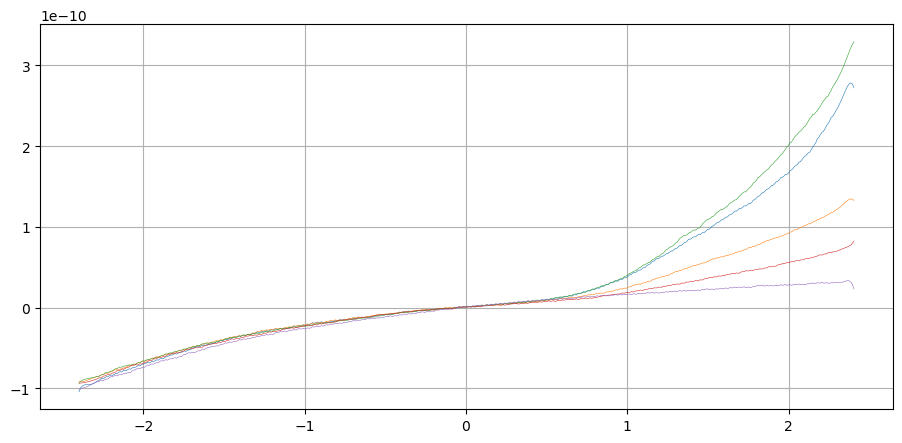

In [11]:
# tworzenie wykresów wszystkich krzywych
x = dataset['x']
y = dataset[dataset.columns[-num_of_points-2:-2]]
w_size = 25

plt.figure(figsize=(11,5))
for column in y.columns:
    print(column)
    y_smoothed = savgol_filter(dataset[column], w_size, 5)
    plt.plot(x, y_smoothed, label=column, linewidth=0.4)
plt.grid('On')
plt.show()

Text(0, 0.5, 'Number of curve')

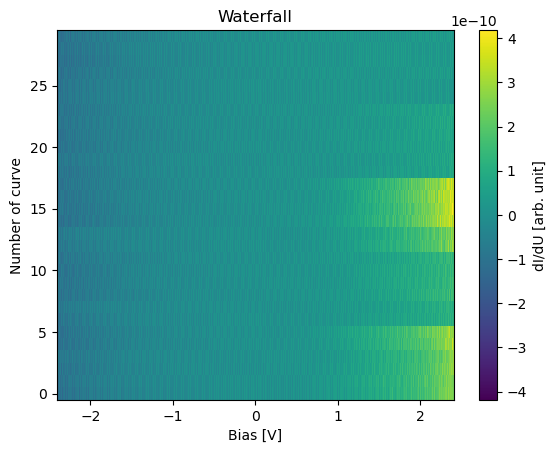

In [12]:
# na moje oko wygląda jak waterfall ale temat do dyskusji, głównie sam wygląd wykresu
# https://matplotlib.org/stable/gallery/color/colormap_reference.html
dIdU.spym.plot(title='Waterfall', cmap='viridis', cbar_kwargs={'label': 'dI/dU [arb. unit]'})
plt.xlabel('Bias [V]')
plt.ylabel('Number of curve')

In [13]:
file.keys()

KeysView(<xarray.Dataset>
Dimensions:                (dI/dU__x: 509, dI/dU__y: 30, Current__x: 509,
                            Current__y: 30, dI/dU__Forward_x: 256,
                            dI/dU__Forward_y: 256, dI/dU__Backward_x: 256,
                            dI/dU__Backward_y: 256, Topography_Forward_x: 256,
                            Topography_Forward_y: 256,
                            Topography_Backward_x: 256,
                            Topography_Backward_y: 256)
Coordinates:
  * dI/dU__x               (dI/dU__x) float64 -2.4 -2.391 -2.381 ... 2.396 2.406
  * dI/dU__y               (dI/dU__y) uint32 0 1 2 3 4 5 6 ... 24 25 26 27 28 29
  * Current__x             (Current__x) float64 -2.4 -2.391 ... 2.396 2.406
  * Current__y             (Current__y) uint32 0 1 2 3 4 5 ... 24 25 26 27 28 29
  * dI/dU__Forward_x       (dI/dU__Forward_x) float64 0.0 ... 5.977e-09
  * dI/dU__Forward_y       (dI/dU__Forward_y) float64 0.0 ... 5.977e-09
  * dI/dU__Backward_x      (dI/dU__B

In [14]:
# wyświetlić nazwę pliku, datę, liczbę punktów, rozmiar obrazka, 

In [15]:
len('1986>	Scan X Size ::')

20

In [16]:
idx_x = file['dI/dU_'].attrs['RHK_PRMdata'].find('<1986>')
idx_x

16959

In [17]:
file['dI/dU_'].attrs['RHK_PRMdata'][idx_x+21:idx_x+24]

'256'

In [18]:
idx = file['dI/dU_'].attrs['RHK_PRMdata'].find('<1322>')
start = file['dI/dU_'].attrs['RHK_PRMdata'][idx:].find('::') + 2 + idx
stop = file['dI/dU_'].attrs['RHK_PRMdata'][idx:].find('\r') + idx

In [19]:
print(start, stop)

16944 16957


In [20]:
file['dI/dU_'].attrs['RHK_PRMdata'][start:stop]

'6.0000e-009 m'

In [21]:
idx = file['dI/dU_'].attrs['RHK_PRMdata'].find('<1833>')
start = file['dI/dU_'].attrs['RHK_PRMdata'][idx:].find('::') + 2 + idx
stop = file['dI/dU_'].attrs['RHK_PRMdata'][idx:].find('\r') + idx

file['dI/dU_'].attrs['RHK_PRMdata'][start:stop]

'ON'

[ 5.81331523e-15  3.08838181e-13  4.13800064e-13 -3.06147079e-12
 -4.49231654e-12  9.83119085e-12  2.28590020e-11  2.27112787e-12
  1.20624246e-11  3.81171064e-14]


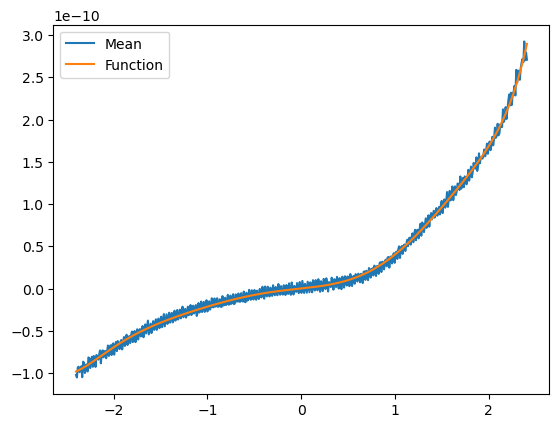

In [22]:
x = dataset['x'].values
y = dataset['mean_p1'].values
_ = plt.plot(x, y, label='Mean')

y_poli = np.polyfit(x, y, deg=9)
print(y_poli)
f = np.poly1d(y_poli)
_ = plt.plot(x, f(x), label='Function')
plt.legend()

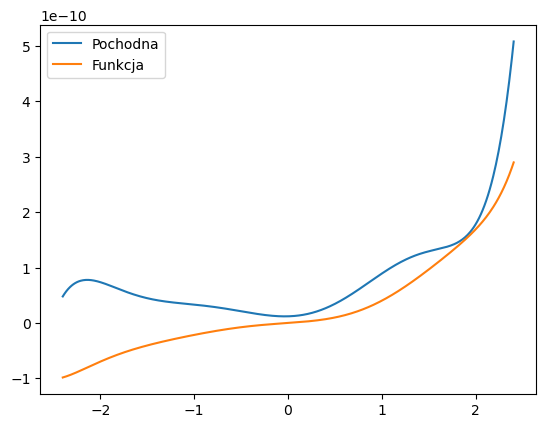

In [23]:
div = nd.Derivative(f, n=1)
#plt.plot(x,y)
plt.plot(x, div(x), label='Pochodna')
plt.plot(x,f(x), label='Funkcja')
plt.legend()

In [24]:
#Operacje matematyczne na krzywych (dodawanie i uśrednianie)
#Wybór wyświetlanych krzywych

In [25]:
start = curves_per_point*num_of_points + 2*num_of_points+1
dataset_mean = dataset.iloc[:, start:-2]
dataset_mean

,mean_p1,mean_p2,mean_p3,mean_p4,mean_p5
0,-1.022339e-10,-9.170532e-11,-9.012858e-11,-9.526571e-11,-9.953817e-11
1,-1.052856e-10,-9.267171e-11,-9.852091e-11,-8.804321e-11,-1.039124e-10
2,-9.333293e-11,-8.773804e-11,-8.738200e-11,-9.653727e-11,-9.867350e-11
3,-9.256999e-11,-8.972168e-11,-8.748372e-11,-9.699504e-11,-9.328206e-11
4,-9.897868e-11,-9.567261e-11,-9.073893e-11,-8.778890e-11,-1.048279e-10
...,...,...,...,...,...
504,2.678426e-10,1.294963e-10,3.131103e-10,7.904053e-11,2.975464e-11
505,2.923584e-10,1.405334e-10,3.059896e-10,7.354736e-11,3.524780e-11
506,2.701823e-10,1.306152e-10,3.298442e-10,8.000692e-11,3.128052e-11
507,2.795410e-10,1.341756e-10,3.265889e-10,7.670085e-11,3.082275e-11


<h1>Test</h1>

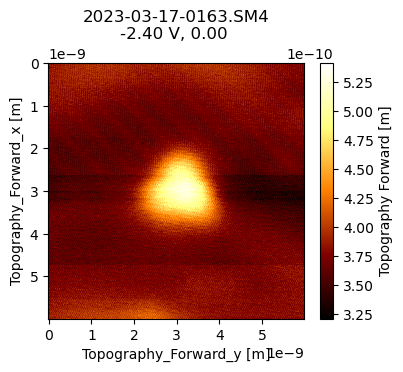

In [26]:
# Rysowanie wykresów spym
tf = file['Topography_Forward']
tf.spym.plot()

Text(0, 0.5, 'y [m]')

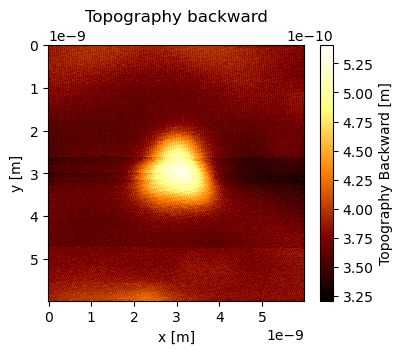

In [27]:
tb = file['Topography_Backward']
plot = tb.spym.plot(title='Topography backward')
plt.xlabel('x [m]')
plt.ylabel('y [m]')

In [28]:
type(plot)

matplotlib.collections.QuadMesh

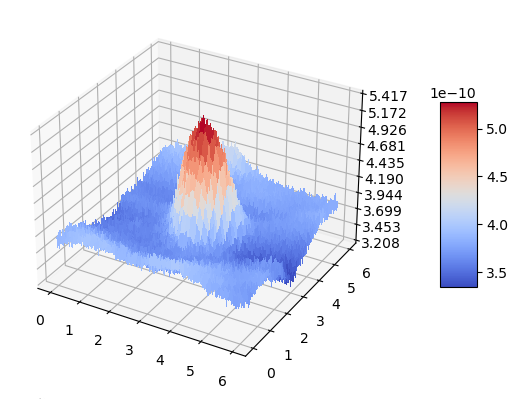

In [29]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

X = tf['Topography_Forward_x'].values
Y = tf['Topography_Forward_y'].values
X, Y = np.meshgrid(X, Y)
Z = tf.values

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_zlim(Z.min(), Z.max())
ax.zaxis.set_major_locator(LinearLocator(10))

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.subplots_adjust(right=2)

plt.show()

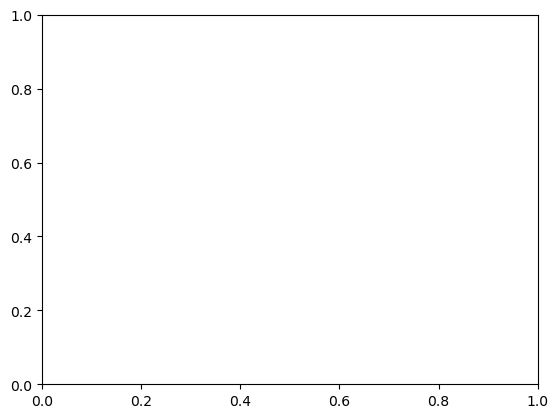

In [30]:
fig, ax = plt.subplots()

In [31]:
type(ax)

matplotlib.axes._axes.Axes

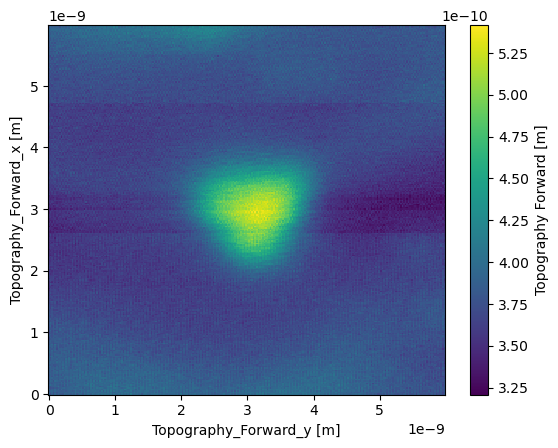

In [32]:
ax = tf.plot()

In [33]:
type(ax)

matplotlib.collections.QuadMesh

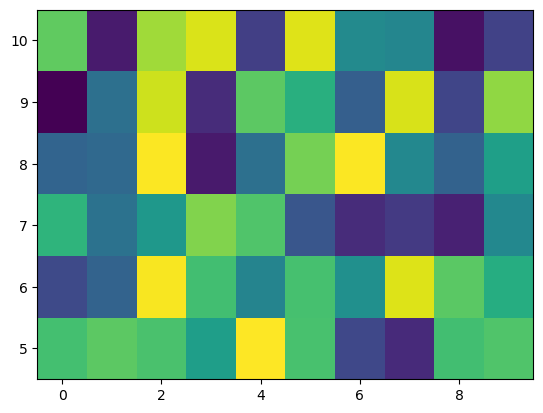

In [34]:
np.random.seed(19680801)
Z = np.random.rand(6, 10)
x = np.arange(-0.5, 10, 1)  # len = 11
y = np.arange(4.5, 11, 1)  # len = 7

fig, ax = plt.subplots()
ax.pcolormesh(x, y, Z)

In [35]:
type(ax)

matplotlib.axes._axes.Axes